In [1]:
import dataclasses
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from q1physrl import phys

/home/matt/.virtualenvs/100m-rl/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
with open("/home/matt/Quakespasm/quakespasm/Quake/accel.txt") as f:
    lines = f.readlines()

In [3]:
def parse_dataframe(lines, prefix, float32_cols, float64_cols):
    records = [json.loads(l.split(' ', 1)[1].strip())
                   for l in lines if l.startswith(prefix)]   
    df = pd.DataFrame.from_records(records)
    
    for col in float32_cols:
        df[col] = df[col].astype('int32').view('float32')

    for col in float64_cols:
        df[col] = df[col].astype('int64').view('float64')
    
    return df

In [4]:
df = parse_dataframe(lines, '@@@FRAME_INPUT@@@',
                     ['yaw', 'pitch', 'roll', 'fmove', 'smove', 'button2', 'velx', 'vely', 'velz', 'z'],
                     ['time', 'host_frametime'])

In [5]:
inputs = phys.Inputs.from_df(df)
player_state = phys.PlayerState.from_df(df)

next_player_state = phys.apply(inputs, player_state)

real_df = player_state.to_df().iloc[1:].reset_index().drop(['index', 'onground', 'jumpreleased'], axis=1)
sim_df = next_player_state.to_df().iloc[:-1].reset_index().drop(['index', 'onground', 'jumpreleased'], axis=1)

/home/matt/100m-rl/q1physrl/phys.py:78: RuntimeWarning: invalid value encountered in true_divide
  wish_vel / unclipped_wish_speed[:, None],
/home/matt/100m-rl/q1physrl/phys.py:83: RuntimeWarning: invalid value encountered in true_divide
  (wish_speed / unclipped_wish_speed),
/home/matt/100m-rl/q1physrl/phys.py:68: RuntimeWarning: invalid value encountered in true_divide
  return np.where((speed > 0)[:, None], h_vel * (new_speed / speed)[:, None], h_vel)


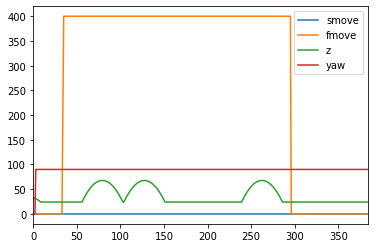

In [6]:
df[['smove', 'fmove', 'z', 'yaw']].plot()

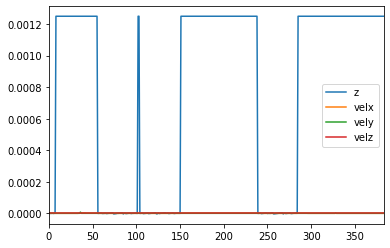

In [8]:
(real_df - sim_df).plot()